# Another attempt at fitting splines with PyMC3

## Setup

In [1]:
from pathlib import Path
from typing import Optional

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import scipy.stats as st
import seaborn as sns
from aesara import tensor as at
from patsy import DesignMatrix, build_design_matrices, dmatrix

In [2]:
from speclet.io import data_dir

In [3]:
pm.__version__

'4.0.0b2'

In [4]:
# Set default theme for 'plotnine'.
gg.theme_set(gg.theme_minimal() + gg.theme(figure_size=(8, 4)))
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Constants
RANDOM_SEED = 847
HDI_PROB = 0.89

## Single spline

### Data

In [5]:
def diff_of_gaussians(
    x: np.ndarray, mus: tuple[float, float], sds: tuple[float, float], noise: float
) -> pd.DataFrame:
    y = (
        st.norm.pdf(x, mus[0], sds[0])
        - st.norm.pdf(x, mus[1], sds[1])
        + np.random.normal(0, noise, size=len(x))
    )
    return pd.DataFrame({"x": x, "y": y})

In [6]:
group_pal = {"a": "#1F77B4", "b": "#FF7F0E"}

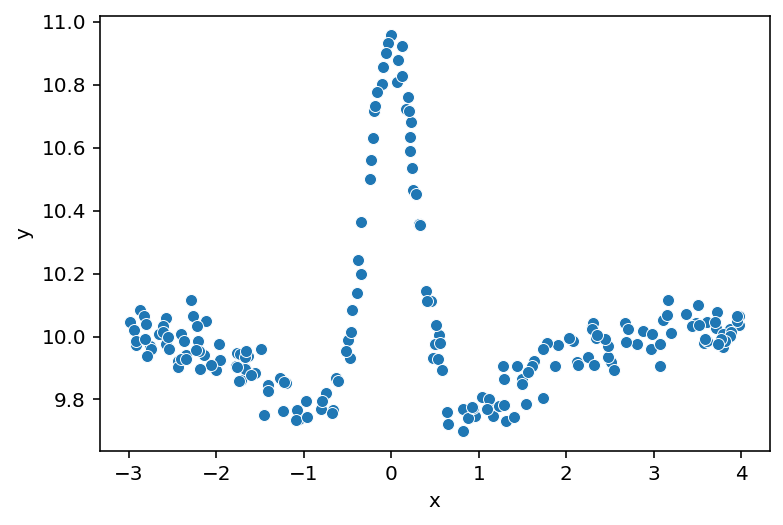

In [7]:
np.random.seed(RANDOM_SEED)

x = np.random.uniform(-3, 4, 200)
data = diff_of_gaussians(x, (0, 0), (0.3, 1), 0.05).assign(y=lambda d: d.y + 10.0)

sns.scatterplot(data=data, x="x", y="y");

### Spline basis

In [8]:
def _make_knot_list(data: pd.DataFrame, num_knots: int = 10) -> np.ndarray:
    return np.quantile(data.x, np.linspace(0, 1, num_knots))


def _build_spline(
    data: pd.DataFrame, knot_list: Optional[np.ndarray] = None, num_knots: int = 10
) -> tuple[np.ndarray, DesignMatrix]:
    if knot_list is None:
        knot_list = _make_knot_list(data, num_knots)

    B = dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
        {"x": data.x.values, "knots": knot_list[1:-1]},
    )
    return knot_list, B

In [9]:
knot_list, B = _build_spline(data)

In [10]:
knot_list

array([-2.98089976, -2.36504627, -1.67490314, -0.72551484, -0.04744339,
        0.50477523,  1.30390392,  2.31655179,  3.43279987,  3.97389701])

In [11]:
B

DesignMatrix with shape (200, 12)
  Columns:
    ['bs(x, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[11]']
  Terms:
    'bs(x, knots=knots, degree=3, include_intercept=True)' (columns 0:12)
  (to view full data, use np.asarray(this_obj))

In [12]:
np.asarray(B).shape

(200, 12)

In [13]:
data.shape

(200, 2)

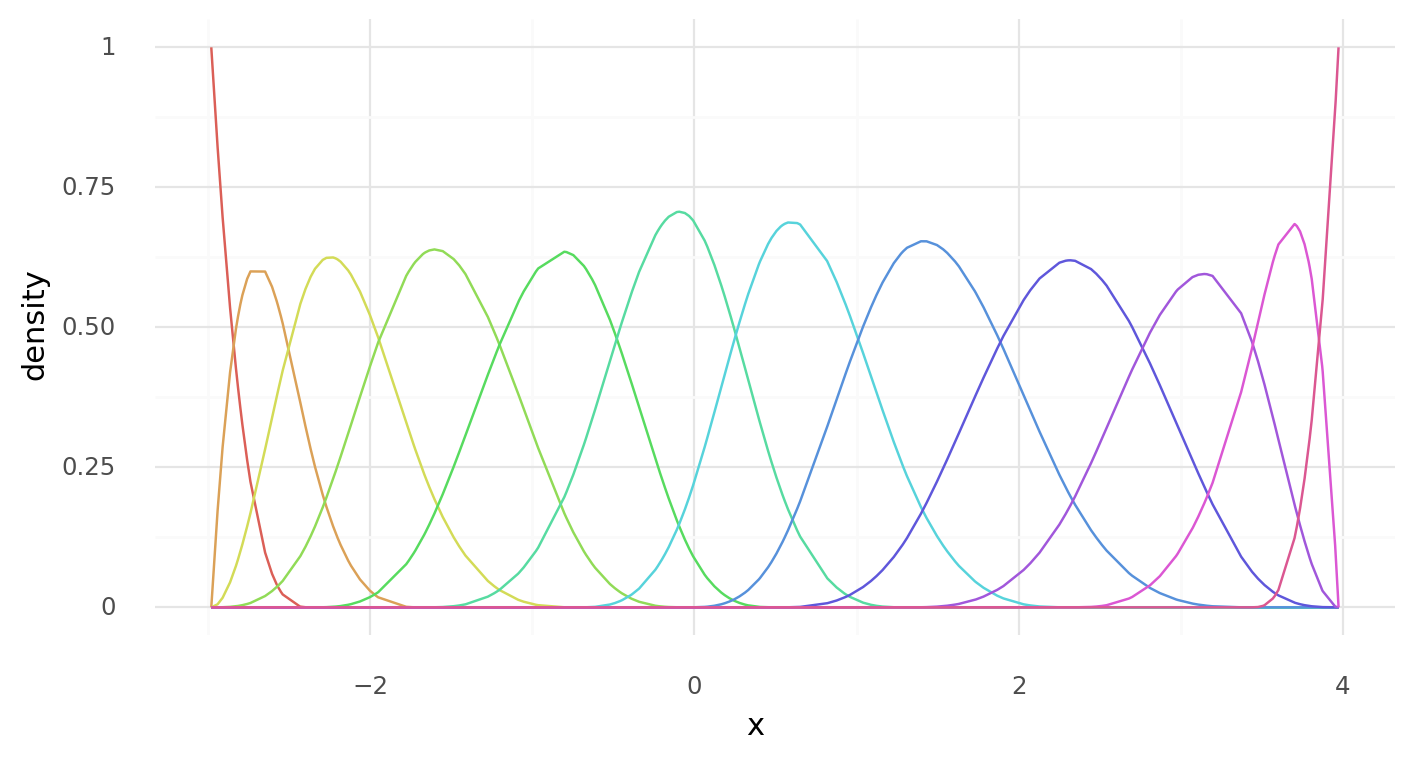

<ggplot: (341429486)>

In [14]:
basis_df = (
    pd.DataFrame(B)
    .reset_index(drop=False)
    .assign(x=data.x.values)
    .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)

(
    gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
    + gg.geom_line()
    + gg.theme(legend_position="none")
)

### Model #1

In [15]:
def build_model1(data: pd.DataFrame, B: DesignMatrix) -> pm.Model:
    B_dim = B.shape[1]

    with pm.Model(rng_seeder=RANDOM_SEED) as m1:
        w = pm.Normal("w", 0, 5, shape=B_dim)
        mu = pm.Deterministic("mu", pm.math.dot(np.asarray(B, order="F"), w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)

    return m1

### Prior predictive

In [16]:
def _build_new_data(
    data: pd.DataFrame, B: DesignMatrix, knots: np.ndarray, n_x: int = 500
) -> tuple[pd.DataFrame, DesignMatrix]:
    new_data = pd.DataFrame(
        {"x": np.linspace(data.x.min(), data.x.max(), num=n_x)}
    ).assign(y=0)
    new_B = build_design_matrices(
        [B.design_info], {"x": new_data.x.values, "knots": knots[1:-1]}
    )[0]
    return new_data, new_B

In [17]:
def _plot_prior(
    prior_pred: az.InferenceData, var_name: str, data: pd.DataFrame
) -> None:
    if var_name == "y":
        var_prior = prior_pred.prior_predictive[var_name].values
    else:
        var_prior = prior_pred.prior[var_name].values
    var_prior = var_prior.squeeze()
    prior_df = (
        pd.DataFrame(var_prior.T)
        .reset_index(drop=False)
        .assign(x=data.x)
        .pivot_longer(["index", "x"], names_to="prior_sample")
        .astype({"prior_sample": str})
    )

    sns.lineplot(data=prior_df, x="x", y="value", hue="prior_sample", legend=None)
    plt.show()

In [18]:
new_data, new_B = _build_new_data(data=data, B=B, knots=knot_list)

In [19]:
with build_model1(data=new_data, B=new_B):
    m1_prior_pred = pm.sample_prior_predictive(samples=10, return_inferencedata=True)

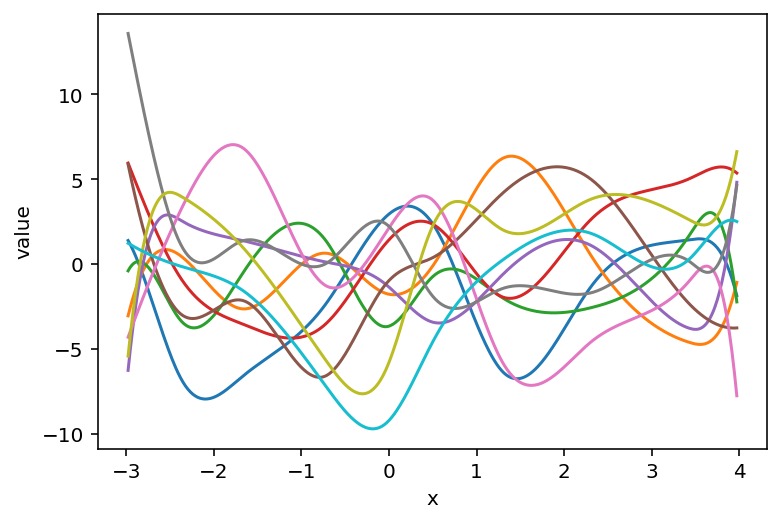

In [20]:
_plot_prior(m1_prior_pred, "mu", data=new_data)

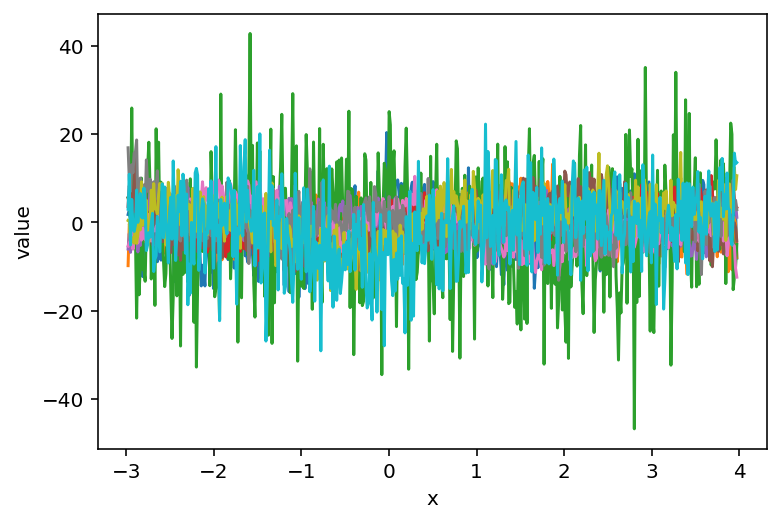

In [21]:
_plot_prior(m1_prior_pred, "y", data=new_data)

### Sample from posterior

In [22]:
pm_sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_ppc_kwargs = {"extend_inferencedata": True}

In [23]:
with build_model1(data=data, B=B):
    m1_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


### Posterior analysis

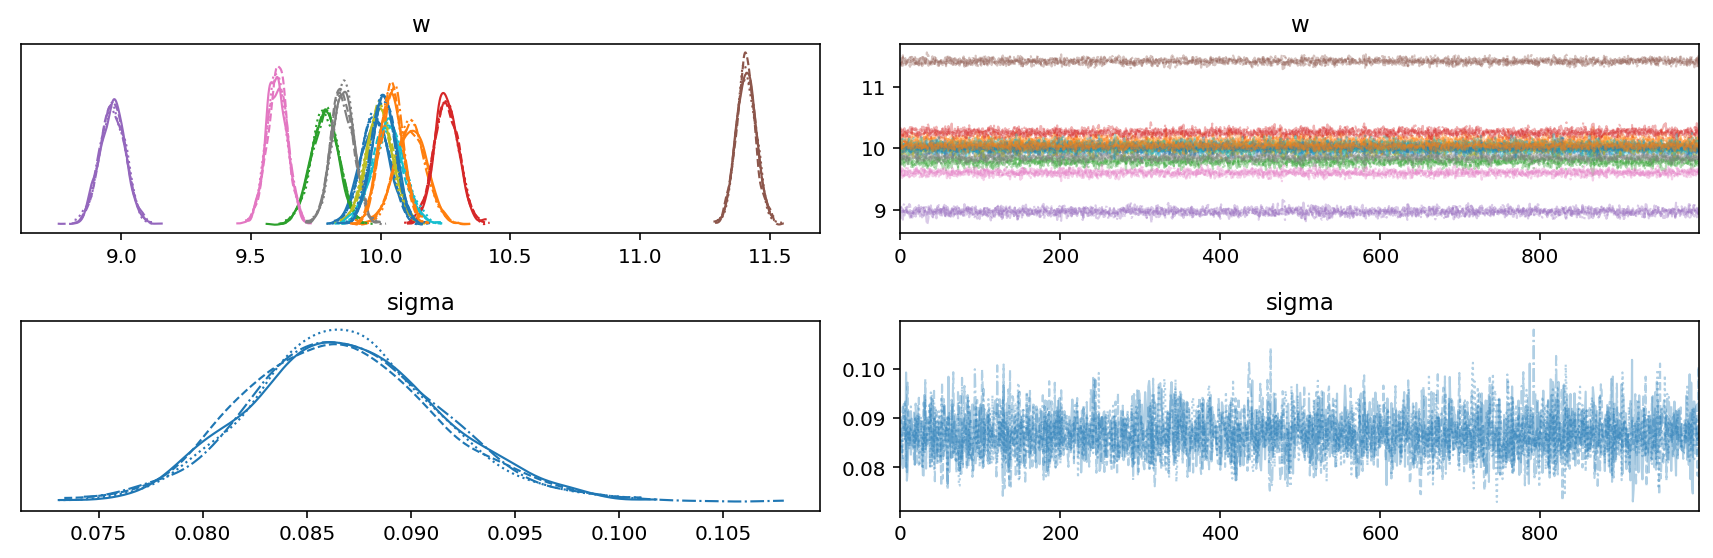

In [24]:
az.plot_trace(m1_trace, var_names=["~mu"])
plt.tight_layout();

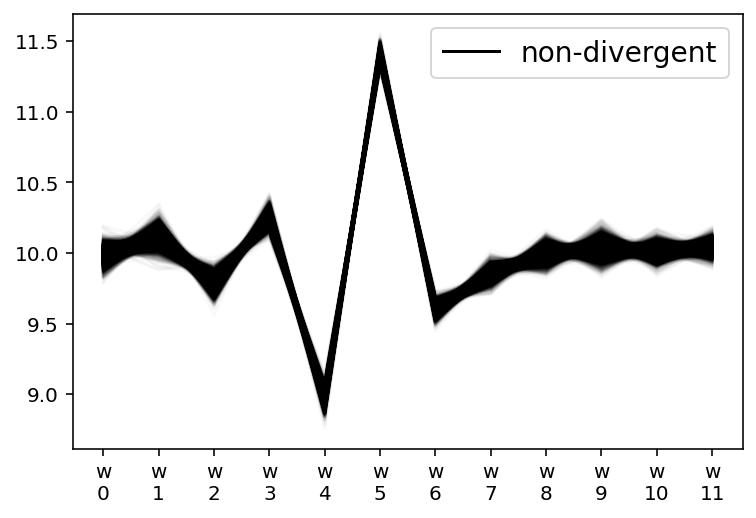

In [25]:
az.plot_parallel(m1_trace, var_names=["w"]);

In [26]:
az.summary(m1_trace, var_names=["~mu"], filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],9.979,0.054,9.881,10.085,0.001,0.001,3329.0,3069.0,1.0
w[1],10.116,0.059,10.012,10.235,0.001,0.001,2550.0,2684.0,1.0
w[2],9.784,0.052,9.678,9.875,0.001,0.001,2267.0,2752.0,1.0
w[3],10.253,0.047,10.165,10.343,0.001,0.001,2305.0,2791.0,1.0
w[4],8.967,0.049,8.871,9.055,0.001,0.001,2426.0,2970.0,1.0
w[5],11.409,0.038,11.337,11.481,0.001,0.001,2108.0,2844.0,1.0
w[6],9.600,0.040,9.522,9.674,0.001,0.001,2004.0,2861.0,1.0
w[7],9.854,0.044,9.779,9.940,0.001,0.001,2326.0,2549.0,1.0
w[8],9.996,0.051,9.902,10.096,0.001,0.001,2249.0,2448.0,1.0
w[9],10.030,0.061,9.918,10.150,0.001,0.001,2297.0,2736.0,1.0


In [27]:
def _plot_posterior_mu(trace: az.InferenceData, data: pd.DataFrame) -> gg.ggplot:
    mu_post_df = (
        az.summary(trace, var_names="mu", hdi_prob=HDI_PROB, kind="stats")
        .reset_index(drop=True)
        .merge(data.copy(), left_index=True, right_index=True)
    )

    if "k" not in data.columns:
        mu_post_df["k"] = "a"

    return (
        gg.ggplot(mu_post_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=0.5)
        + gg.geom_ribbon(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="mean", color="k"), size=0.5)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

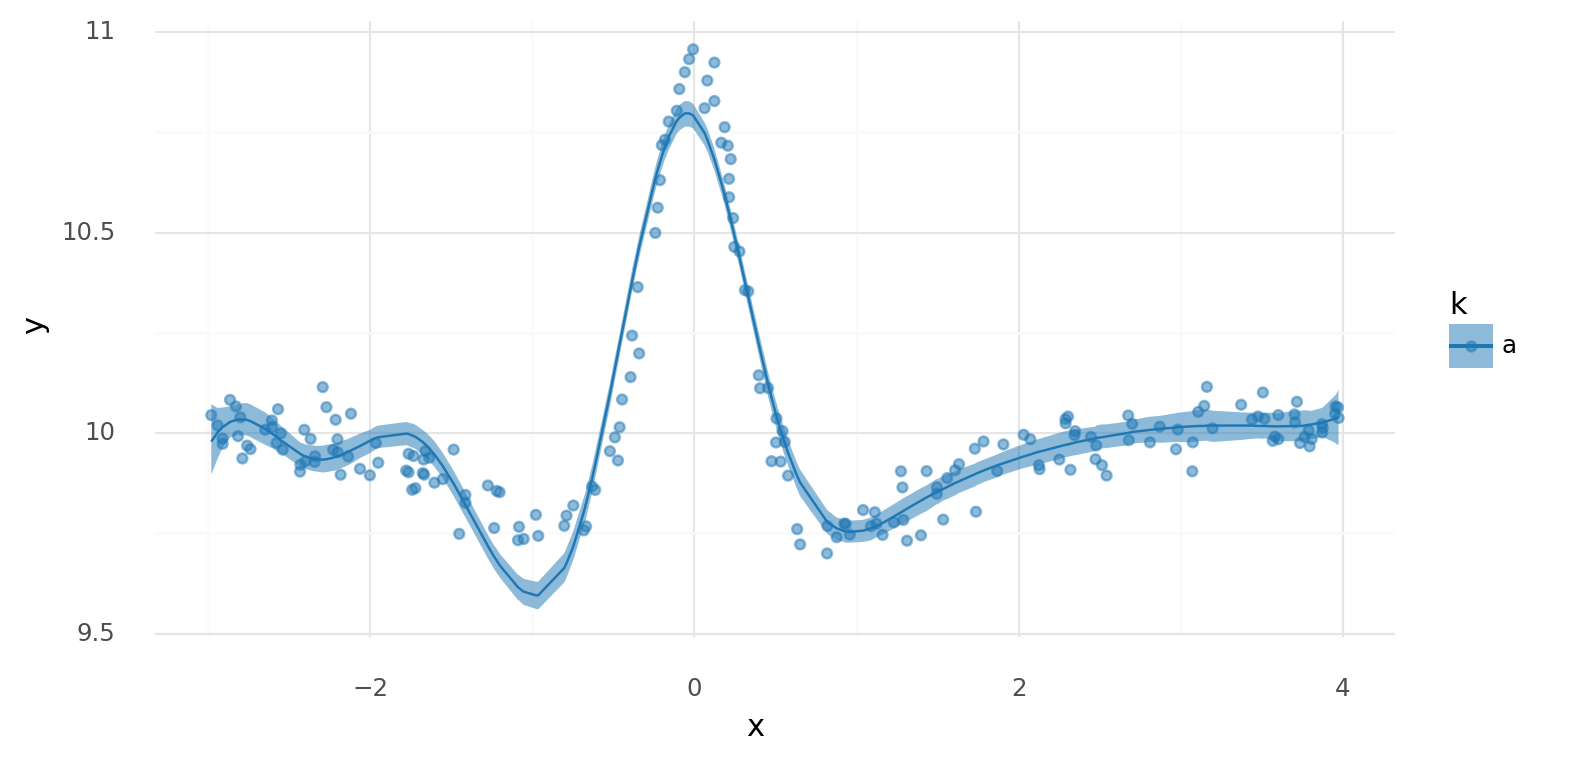

<ggplot: (345277998)>

In [28]:
_plot_posterior_mu(m1_trace, data=data)

In [29]:
def _plot_ppc(trace: az.InferenceData, data: pd.DataFrame) -> gg.ggplot:
    post_pred = trace.posterior_predictive["y"].values.reshape(-1, data.shape[0])
    ppc_avg = post_pred.mean(0)
    ppc_hdi = az.hdi(post_pred, hdi_prob=HDI_PROB)

    plot_df = data.copy().assign(
        post_pred=ppc_avg, hdi_low=ppc_hdi[:, 0], hdi_high=ppc_hdi[:, 1]
    )

    if "k" not in data.columns:
        plot_df["k"] = np.repeat(["a"], plot_df.shape[0])

    return (
        gg.ggplot(plot_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=0.5)
        + gg.geom_ribbon(gg.aes(ymin="hdi_low", ymax="hdi_high", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="post_pred", color="k"), size=1)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_37054/3784358657.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


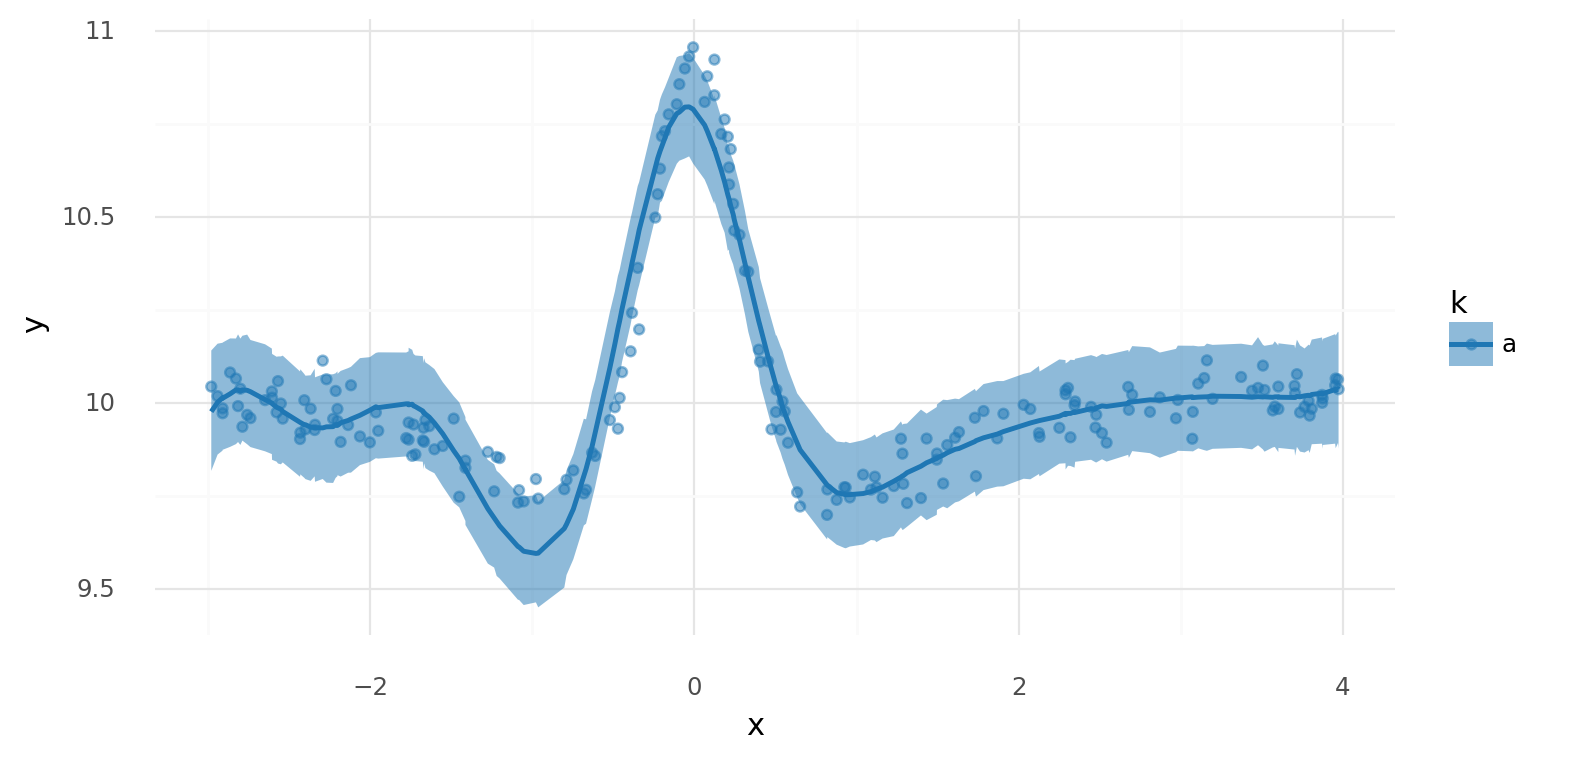

<ggplot: (345143257)>

In [30]:
_plot_ppc(m1_trace, data)

## Two groups, single spline

### Data

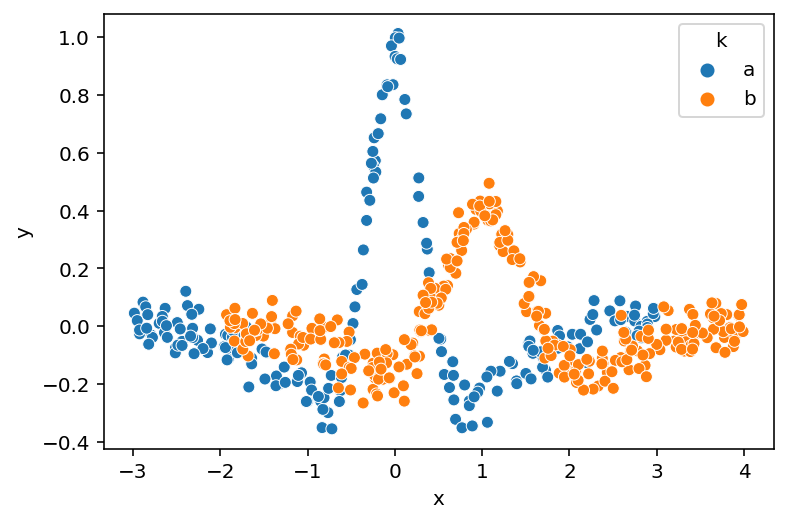

In [31]:
np.random.seed(RANDOM_SEED)

x1 = np.random.uniform(-3, 3, 200)
d1 = diff_of_gaussians(x1, (0, 0), (0.3, 1), 0.05).assign(k="a")
x2 = np.random.uniform(-3, 3, 300) + 1
d2 = diff_of_gaussians(x2, (1, 1), (0.5, 1), 0.05).assign(k="b")

data2 = pd.concat([d1, d2]).reset_index(drop=True)
data2["k"] = pd.Categorical(data2["k"], categories=["a", "b"], ordered=True)

sns.scatterplot(data=data2, x="x", y="y", hue="k", palette=group_pal);

### Spline

In [32]:
knot2, B2 = _build_spline(data2)

### Sample from posterior

In [33]:
with build_model1(data=data2, B=B2):
    m1_trace2 = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace2, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


### Posterior analysis

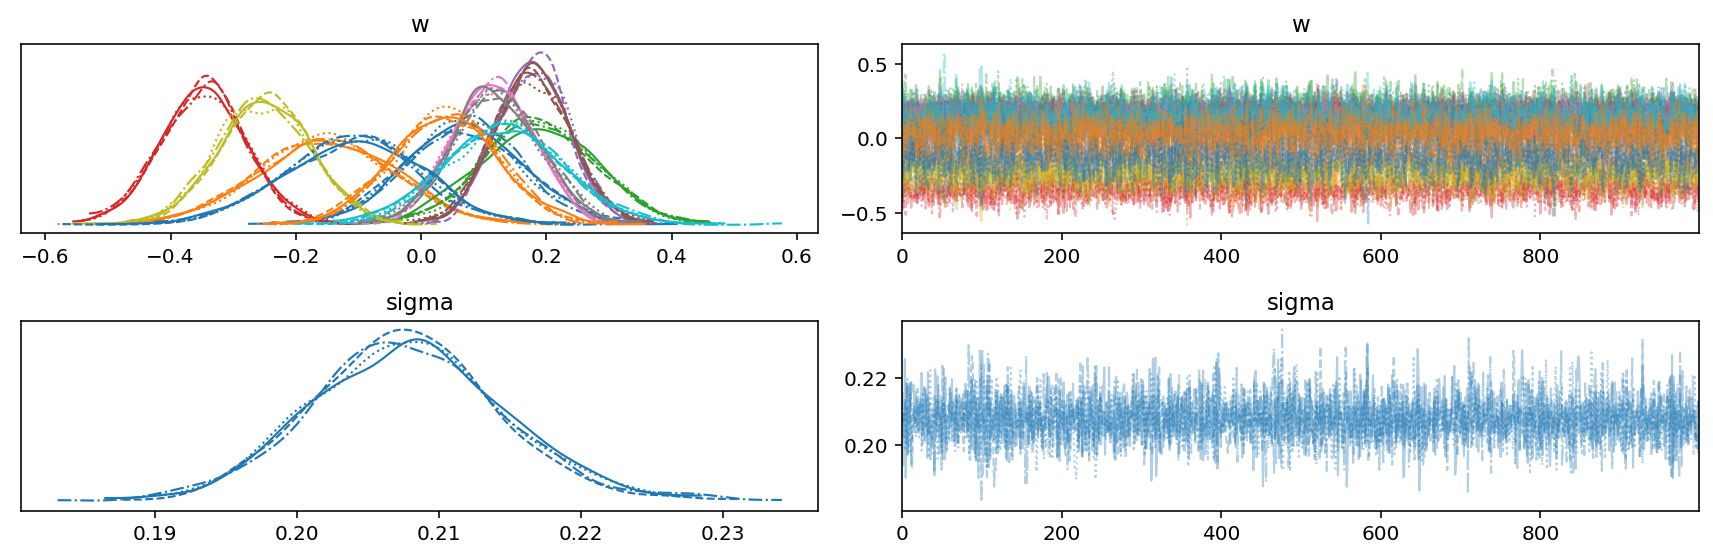

In [34]:
az.plot_trace(m1_trace2, var_names=["~mu"])
plt.tight_layout();

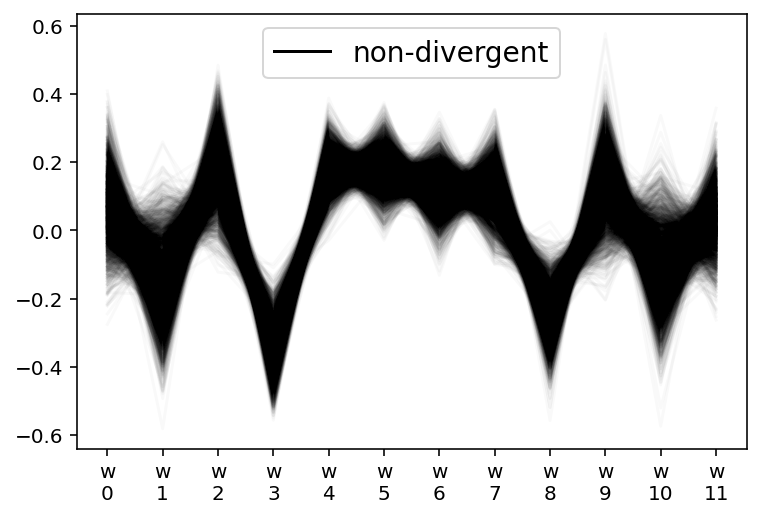

In [35]:
az.plot_parallel(m1_trace2, var_names=["w"]);

In [36]:
az.summary(m1_trace2, var_names=["~mu"], filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.069,0.094,-0.099,0.256,0.002,0.001,3031.0,2866.0,1.0
w[1],-0.153,0.108,-0.358,0.048,0.002,0.002,2387.0,2911.0,1.0
w[2],0.188,0.090,0.017,0.355,0.002,0.001,1996.0,2417.0,1.0
w[3],-0.348,0.068,-0.478,-0.221,0.001,0.001,2057.0,2448.0,1.0
w[4],0.179,0.057,0.070,0.284,0.001,0.001,2067.0,2577.0,1.0
w[5],0.177,0.061,0.060,0.288,0.001,0.001,2259.0,2655.0,1.0
w[6],0.115,0.066,-0.004,0.241,0.001,0.001,2212.0,3034.0,1.0
w[7],0.120,0.071,-0.010,0.254,0.002,0.001,2076.0,2620.0,1.0
w[8],-0.251,0.074,-0.385,-0.111,0.002,0.001,1977.0,2428.0,1.0
w[9],0.134,0.095,-0.042,0.320,0.002,0.001,2155.0,2753.0,1.0


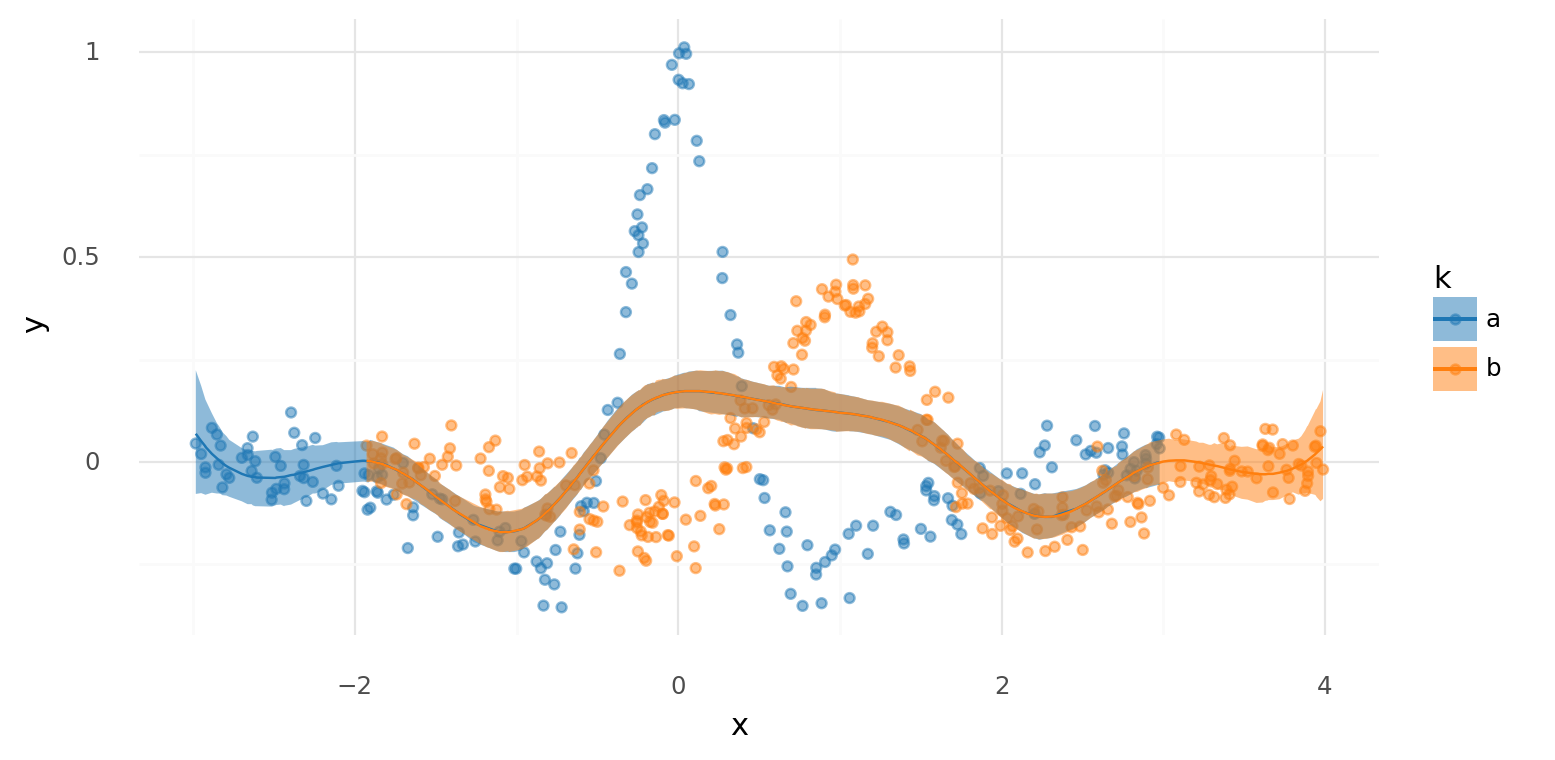

<ggplot: (344944890)>

In [37]:
_plot_posterior_mu(m1_trace2, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_37054/3784358657.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


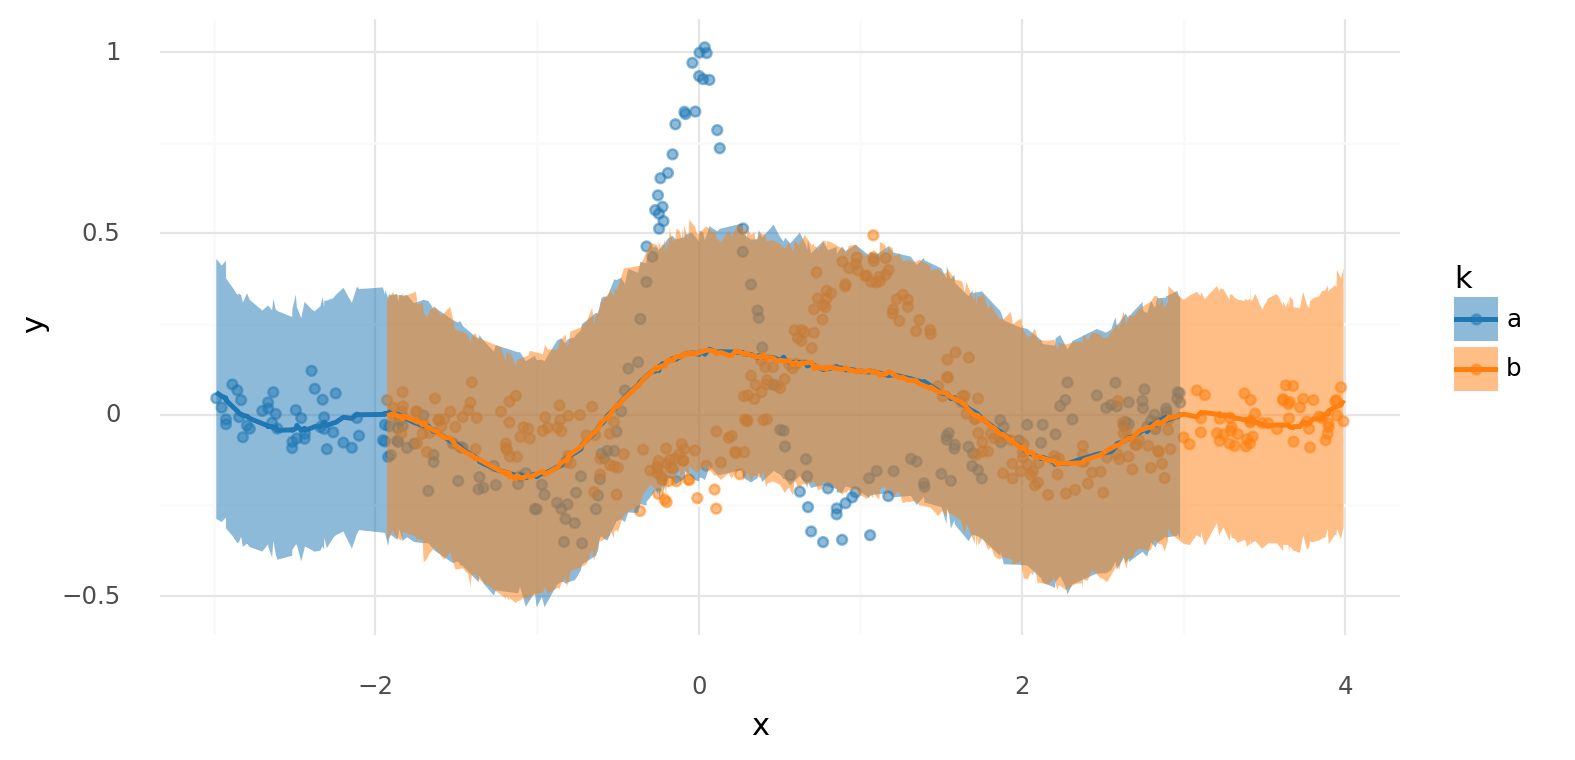

<ggplot: (345502504)>

In [38]:
_plot_ppc(m1_trace2, data2)

## Multi-group, multi-basis spline

### Spline basis

In [39]:
knots = _make_knot_list(data2)

In [40]:
spline_list: list[DesignMatrix] = []
for k in data2.k.unique():
    data_k = data2.query(f"k=='{k}'").reset_index(drop=True)
    _, B_k = _build_spline(data_k, knot_list=knots)
    spline_list.append(B_k)

print(len(spline_list))

2


In [41]:
B_k = [np.asarray(b) for b in spline_list]

In [42]:
for b in B_k:
    print(b.shape)

(200, 12)
(300, 12)


In [43]:
B_2 = np.vstack(B_k)
B_2.shape

(500, 12)

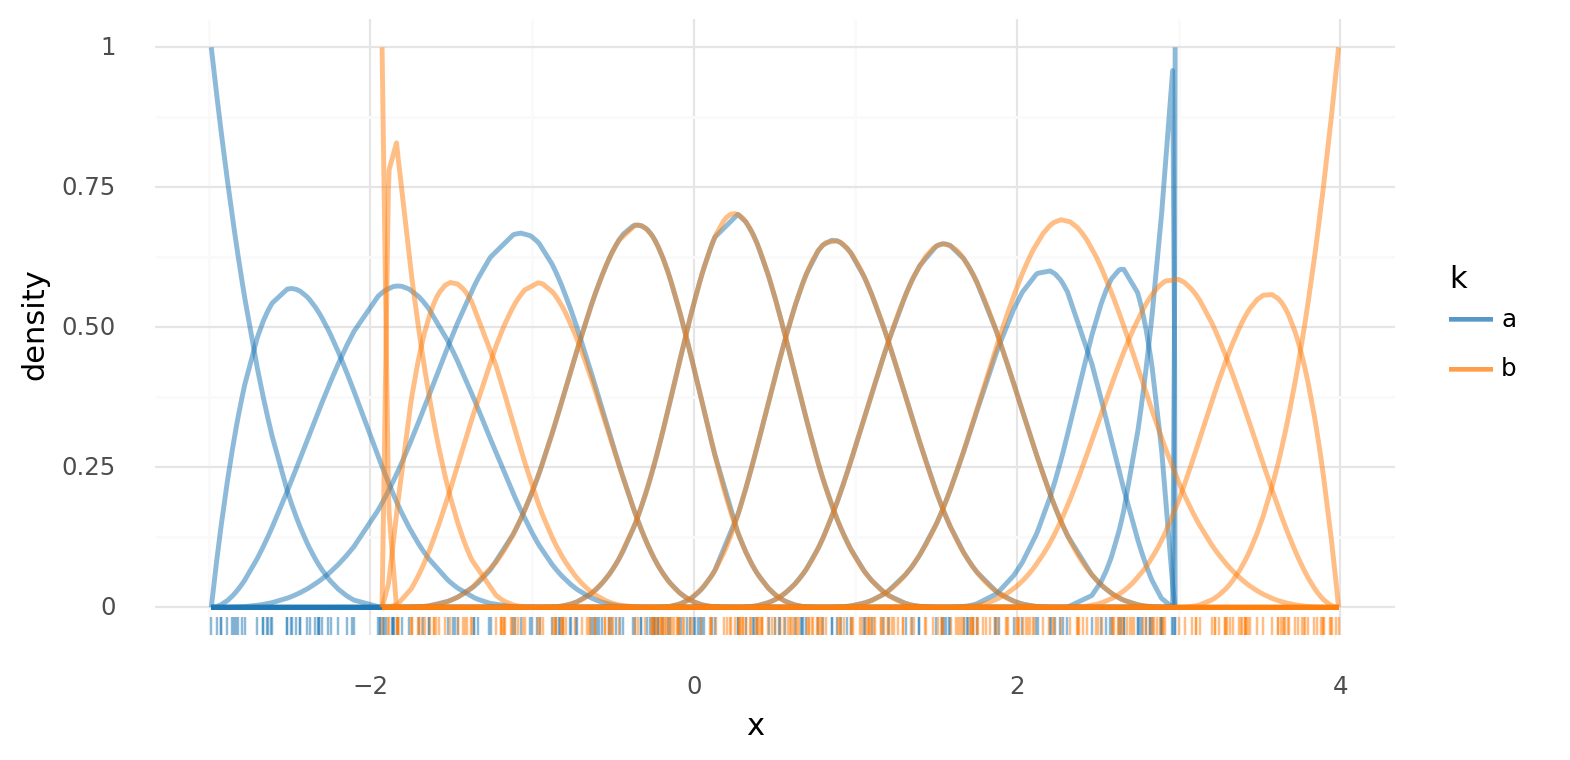

<ggplot: (345493631)>

In [44]:
basis_df = (
    pd.DataFrame(B_2)
    .assign(k=data2.k.values, x=data2.x.values)
    .pivot_longer(["k", "x"], names_to="basis", values_to="density")
    .assign(basis=lambda d: [f"{k}: {x}" for x, k in zip(d.basis, d.k)])
)
(
    gg.ggplot(basis_df, gg.aes(x="x", color="k"))
    + gg.geom_line(gg.aes(group="basis", y="density"), alpha=0.5, size=1)
    + gg.geom_rug(data=data2, alpha=0.5, sides="b")
    + gg.scale_color_manual(values=group_pal)
)

### Model #2

In [45]:
def build_model2(data: pd.DataFrame, B_k: list[np.ndarray]) -> pm.Model:
    B_dim = B_k[0].shape[1]
    stacked_B = np.vstack(B_k)
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m2:
        B = pm.Data("B", stacked_B, mutable=False)
        w = pm.Normal("w", 0, 5, shape=(B_dim, 2))
        _mu = []
        for i in range(2):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m2

In [46]:
m2 = build_model2(data2, B_k)
m2

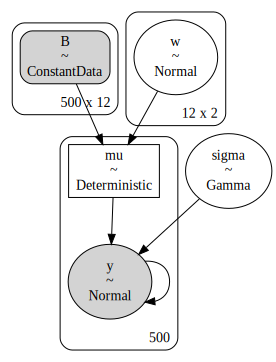

In [47]:
pm.model_to_graphviz(m2)

### Sample from posterior

In [48]:
with build_model2(data=data2, B_k=B_k):
    m2_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m2_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


### Posterior analysis

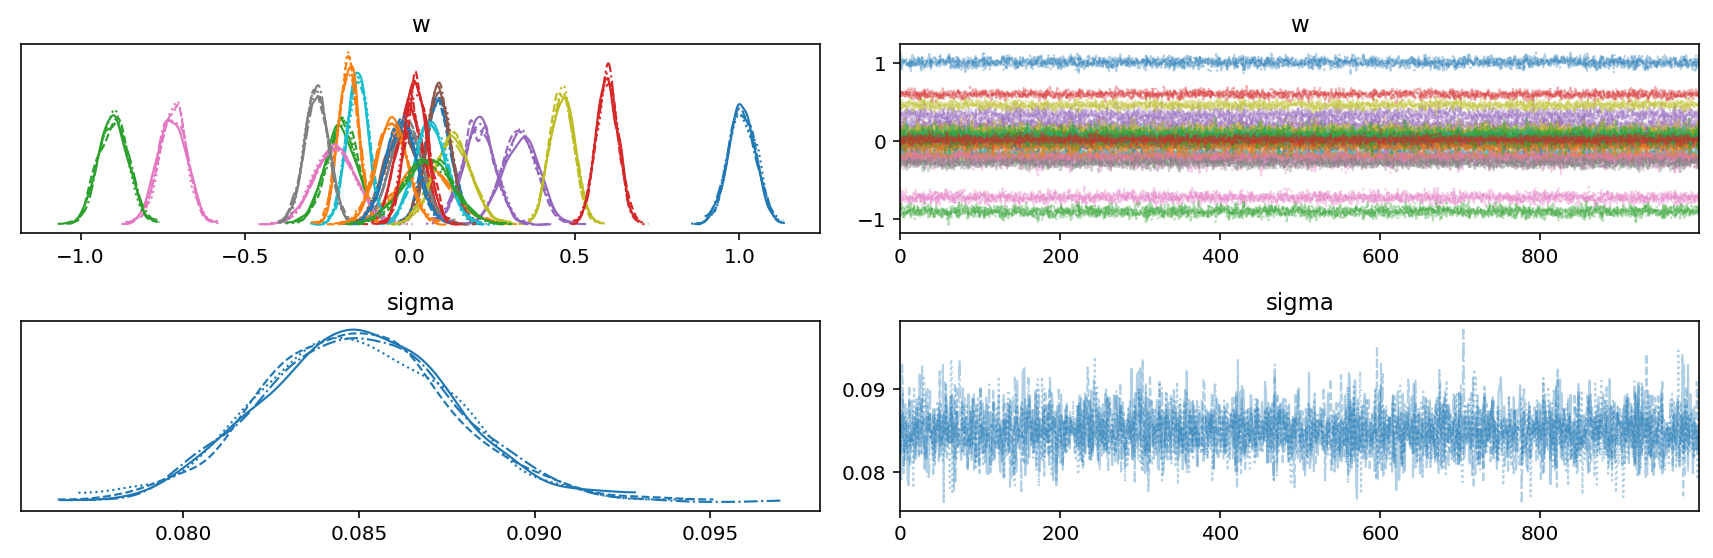

In [49]:
az.plot_trace(m2_trace, var_names=["~mu"])
plt.tight_layout();

In [50]:
az.summary(m2_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w[0, 0]",0.085,0.039,0.021,0.146,0.001,0.000,4357.0,3511.0,1.0
"w[0, 1]",0.041,0.083,-0.098,0.169,0.001,0.001,5405.0,3014.0,1.0
"w[1, 0]",-0.206,0.050,-0.283,-0.124,0.001,0.001,2691.0,2735.0,1.0
"w[1, 1]",-0.002,0.040,-0.064,0.064,0.001,0.001,4212.0,3464.0,1.0
"w[2, 0]",0.334,0.053,0.248,0.416,0.001,0.001,2655.0,2696.0,1.0
"w[2, 1]",-0.025,0.052,-0.103,0.061,0.001,0.001,2850.0,2947.0,1.0
"w[3, 0]",-0.720,0.043,-0.786,-0.650,0.001,0.001,2785.0,2916.0,1.0
"w[3, 1]",-0.012,0.047,-0.092,0.059,0.001,0.001,2972.0,3135.0,1.0
"w[4, 0]",0.462,0.036,0.403,0.518,0.001,0.000,2821.0,2896.0,1.0
"w[4, 1]",-0.159,0.032,-0.209,-0.106,0.001,0.000,2623.0,2691.0,1.0


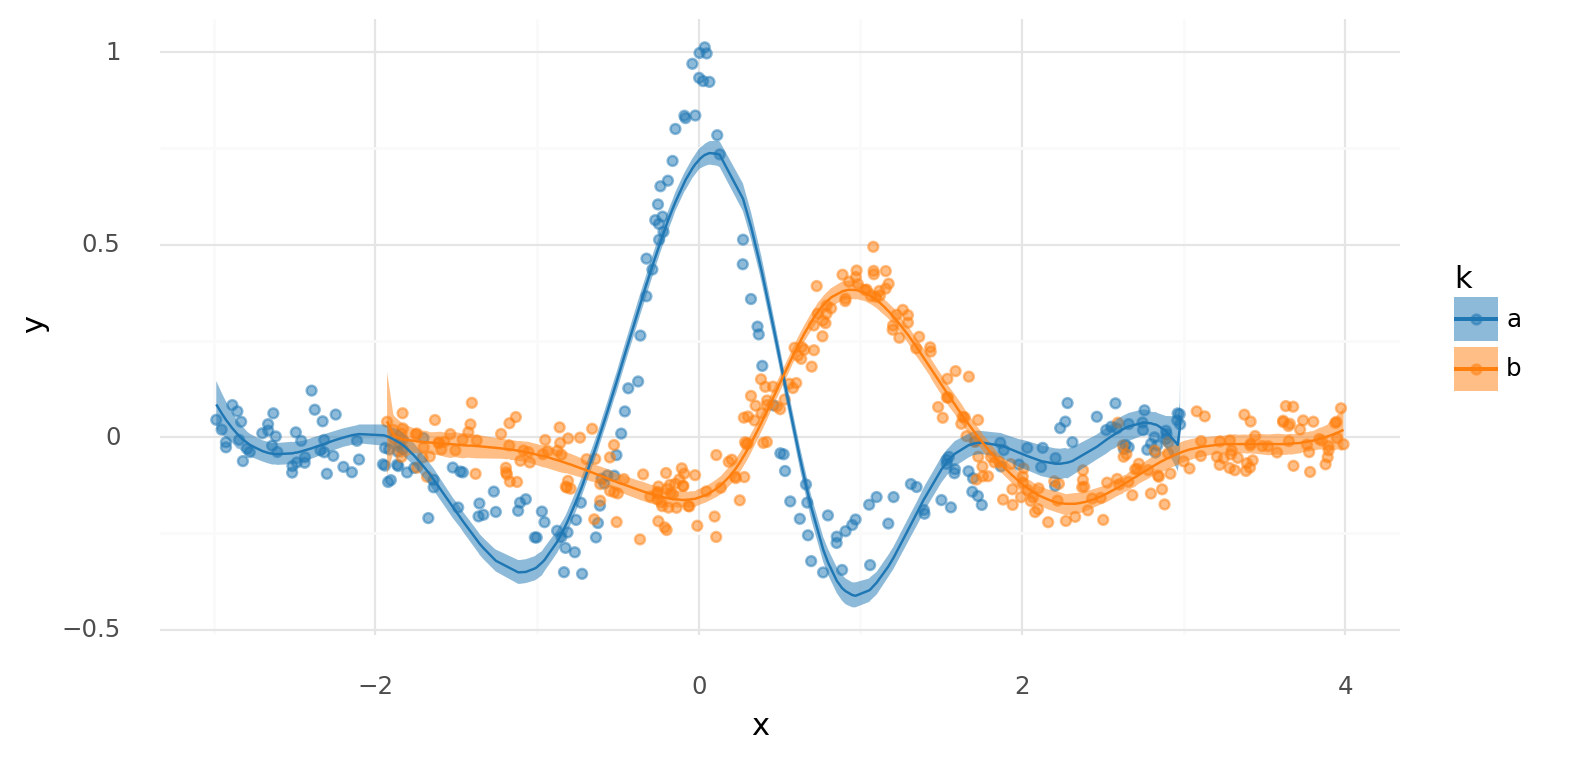

<ggplot: (345718634)>

In [51]:
_plot_posterior_mu(m2_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_37054/3784358657.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


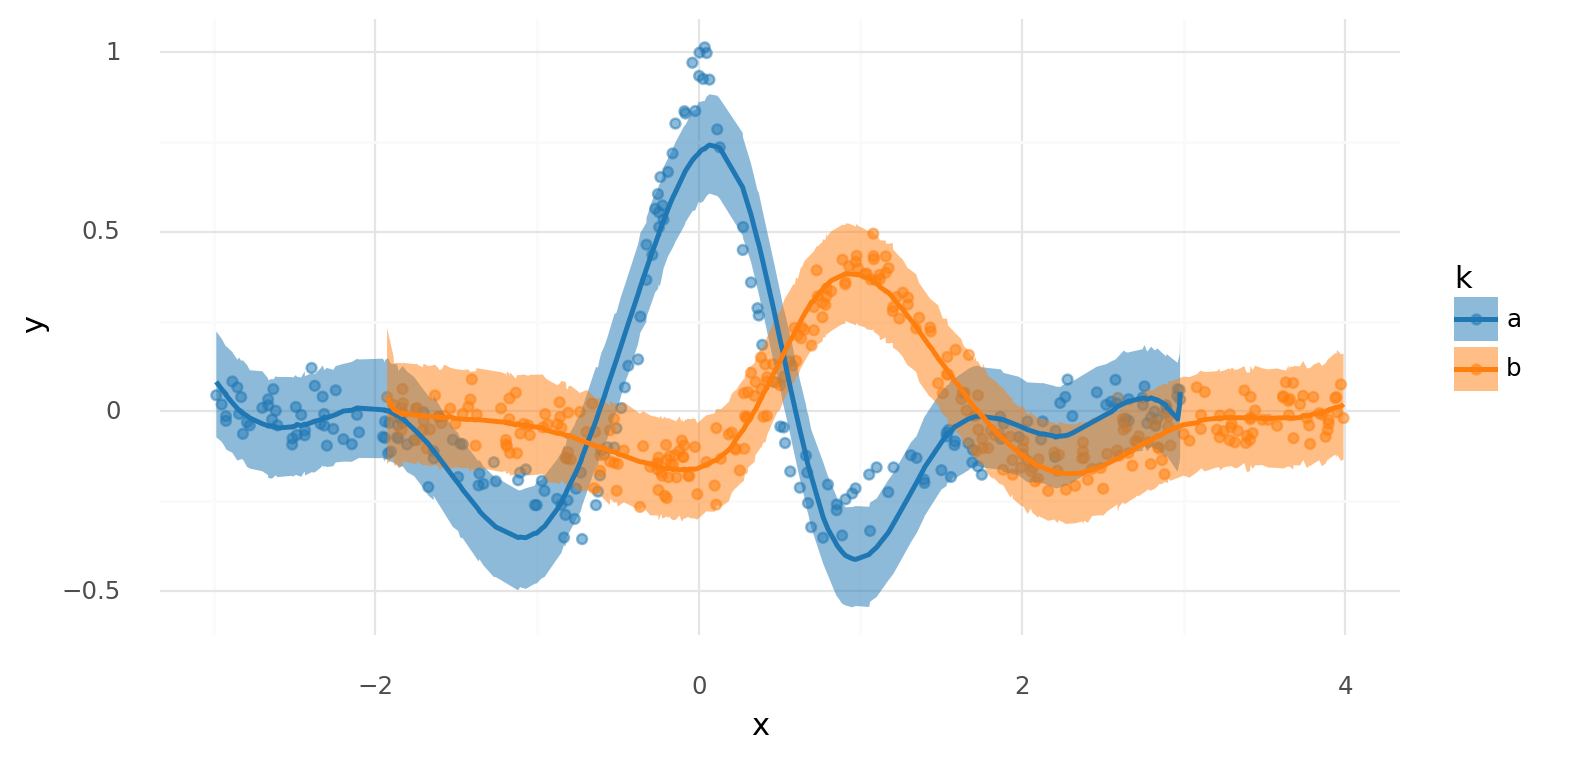

<ggplot: (343033311)>

In [52]:
_plot_ppc(m2_trace, data2)

---

In [53]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-17

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

pandas    : 1.4.1
arviz     : 0.11.4
matplotlib: 3.5.1
aesara    : 2.3.8
numpy     : 1.22.2
pymc      : 4.0.0b2
plotnine  : 0.8.0
seaborn   : 0.11.2
janitor   : 0.22.0
scipy     : 1.7.3

